In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import kruskal
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
df = pd.read_csv("../archive/sleepdata.csv",sep=";", parse_dates=["Start", "End"])

In [3]:
df

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps)
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100%,8:32,:),NaN,59.0,0
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3%,0:16,:|,Stressful day,72.0,0
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98%,8:30,:|,NaN,57.0,0
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65%,7:32,NaN,NaN,NaN,0
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72%,6:44,:),Drank coffee:Drank tea,68.0,0
...,...,...,...,...,...,...,...,...
882,2018-02-12 21:54:14,2018-02-13 07:02:15,91%,9:08,NaN,NaN,NaN,56
883,2018-02-13 23:49:19,2018-02-14 07:00:53,81%,7:11,NaN,NaN,NaN,64
884,2018-02-14 21:24:05,2018-02-15 06:20:52,71%,8:56,NaN,NaN,NaN,3316
885,2018-02-15 21:36:32,2018-02-16 06:50:31,80%,9:13,NaN,NaN,NaN,6555


In [4]:
df.dtypes

Start               datetime64[ns]
End                 datetime64[ns]
Sleep quality               object
Time in bed                 object
Wake up                     object
Sleep Notes                 object
Heart rate                 float64
Activity (steps)             int64
dtype: object

### Check missing values

In [5]:
df.isnull().sum()

Start                 0
End                   0
Sleep quality         0
Time in bed           0
Wake up             641
Sleep Notes         235
Heart rate          725
Activity (steps)      0
dtype: int64

In [6]:
df["Sleep quality"] = (df["Sleep quality"].str.replace("%", "", regex=False).astype(float))


Many of the Wake up, Sleep Notes and Heart rate are missing so we drop this.

In [14]:
#convert time in bed to minutes
def time_to_minutes(time_str):
    if pd.isna(time_str):
        return None

    hours, minutes = time_str.split(":")
    return int(hours) * 60 + int(minutes)
    
df["time_in_minutes"] = df["Time in bed"].apply(time_to_minutes)

In [16]:
df

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps),time_in_minutes
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100.0,8:32,:),NaN,59.0,0,512
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3.0,0:16,:|,Stressful day,72.0,0,16
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98.0,8:30,:|,NaN,57.0,0,510
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65.0,7:32,NaN,NaN,NaN,0,452
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72.0,6:44,:),Drank coffee:Drank tea,68.0,0,404
...,...,...,...,...,...,...,...,...,...
882,2018-02-12 21:54:14,2018-02-13 07:02:15,91.0,9:08,NaN,NaN,NaN,56,548
883,2018-02-13 23:49:19,2018-02-14 07:00:53,81.0,7:11,NaN,NaN,NaN,64,431
884,2018-02-14 21:24:05,2018-02-15 06:20:52,71.0,8:56,NaN,NaN,NaN,3316,536
885,2018-02-15 21:36:32,2018-02-16 06:50:31,80.0,9:13,NaN,NaN,NaN,6555,553


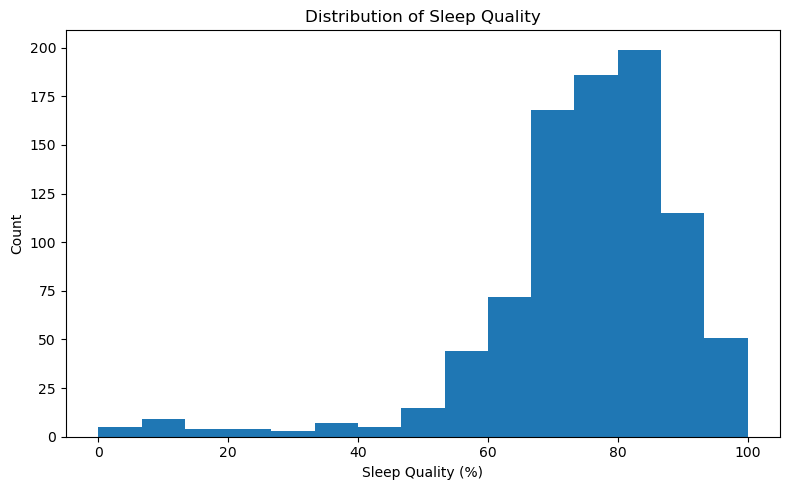

In [9]:
plt.figure(figsize=(8, 5))
plt.hist(df["Sleep quality"], bins=15)
plt.xlabel("Sleep Quality (%)")
plt.ylabel("Count")
plt.title("Distribution of Sleep Quality")
plt.tight_layout()
plt.show()


The distribution is left skewed, with majorly high sleep quality

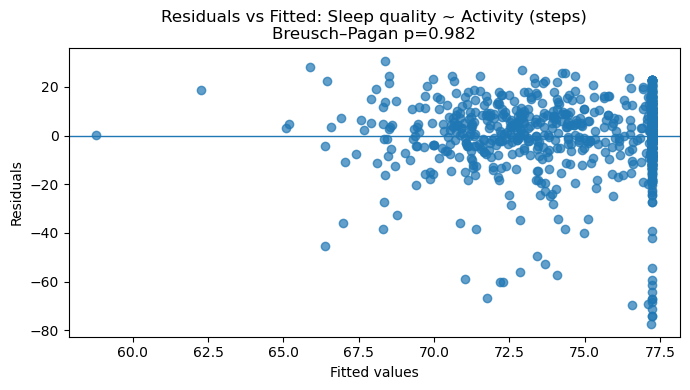

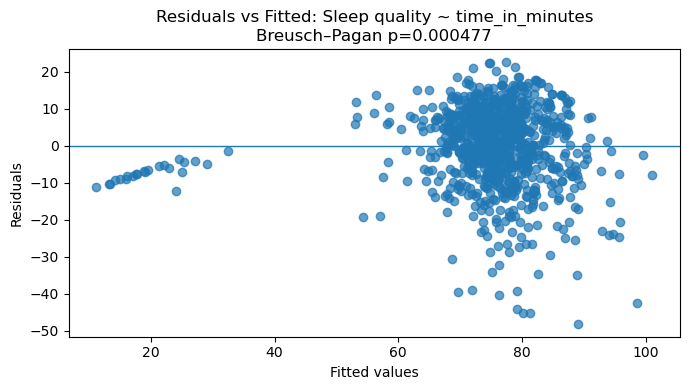

,feature,n,bp_lm_stat,bp_lm_pvalue,bp_f_stat,bp_f_pvalue
0,Activity (steps),887,0.000508,0.982022,0.000507,0.982047
1,time_in_minutes,887,12.204072,0.000477,12.346427,0.000464


In [23]:
target = "Sleep quality"
features = ["Activity (steps)", "time_in_minutes"]

results = []

for x_col in features:
    # Pairwise clean data
    d = df[[target, x_col]].dropna().copy()

    # OLS: y ~ x
    X = sm.add_constant(d[x_col])
    y = d[target]
    model = sm.OLS(y, X).fit()

    fitted = model.fittedvalues
    resid = model.resid

    # Breusch–Pagan test (H0: homoscedasticity)
    # returns: LM stat, LM p-value, F stat, F p-value
    lm_stat, lm_p, f_stat, f_p = het_breuschpagan(resid, model.model.exog)

    results.append({
        "feature": x_col,
        "n": len(d),
        "bp_lm_stat": lm_stat,
        "bp_lm_pvalue": lm_p,
        "bp_f_stat": f_stat,
        "bp_f_pvalue": f_p
    })

    # Residuals vs Fitted plot
    plt.figure(figsize=(7, 4))
    plt.scatter(fitted, resid, alpha=0.7)
    plt.axhline(0, linewidth=1)
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs Fitted: {target} ~ {x_col}\nBreusch–Pagan p={lm_p:.3g}")
    plt.tight_layout()
    plt.show()

# Summary table
het_df = pd.DataFrame(results)
het_df



## From the residual plots
- There is funnel-like spread for time in minutes, and residual variance increases with fitted values
- This shows a clear heteroscedasticity for time in minutes. Hence spearman correlation is more suitable to check the correlation. Remember that pearson correlation assumes homoscedasticity.
- For Activity (steps), residuals look more evenly spread. No obvious funnel pattern. This is much closer to homoscedasticity. Pearson correlation test is sufficient for this.
- Breusch–Pagan test confirms that there is No evidence of heteroscedasticity for Activity (steps), and strong evidence of heteroscedasticity for time in minutes
- For convenience, I get both the pearson and spearman correlation for both variables

In [18]:
target = "Sleep quality"
features = ["Activity (steps)", "time_in_minutes"]

corr_results = []

for var in features:
    # Drop missing values pairwise
    df_clean = df[[target, var]].dropna()

    # Pearson correlation + p-value
    pearson_r, pearson_p = pearsonr(
        df_clean[target],
        df_clean[var]
    )

    # Spearman correlation + p-value
    spearman_r, spearman_p = spearmanr(
        df_clean[target],
        df_clean[var]
    )

    corr_results.append({
        "variable": var,
        "pearson_r": pearson_r,
        "pearson_p": pearson_p,
        "spearman_r": spearman_r,
        "spearman_p": spearman_p,
        "n": len(df_clean)
    })

corr_df = (
    pd.DataFrame(corr_results)
    .sort_values(by="spearman_r", key=abs, ascending=False)
)

corr_df


,variable,pearson_r,pearson_p,spearman_r,spearman_p,n
1,time_in_minutes,0.711353,1.099301e-137,0.460601,8.684960e-48,887
0,Activity (steps),-0.190491,1.079420e-08,-0.241371,3.180706e-13,887


- We see that time in minutes is positively correlated (monotonic association) with sleep quality while activity steps is slightly negative correlated with sleep quality. In both cases, the results are statistically significant at a p-level of 0.05.
- Interestingly,Higher daily steps are weakly associated with lower sleep quality. This does not imply:Exercise is harmful, Causality. It likely reflects: Timing effects (late activity). Overexertion. Confounding by stress, workdays, or lifestyle factors

### Now, we extract the sleep time and wake time hour, as this might be useful features as well

In [24]:
df["start_hour"] = df["Start"].dt.hour
df["end_hour"] = df["End"].dt.hour

In [25]:
df

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps),time_in_minutes,start_hour,end_hour
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100.0,8:32,:),NaN,59.0,0,512,22,7
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3.0,0:16,:|,Stressful day,72.0,0,16,21,21
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98.0,8:30,:|,NaN,57.0,0,510,22,7
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65.0,7:32,NaN,NaN,NaN,0,452,22,6
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72.0,6:44,:),Drank coffee:Drank tea,68.0,0,404,22,4
...,...,...,...,...,...,...,...,...,...,...,...
882,2018-02-12 21:54:14,2018-02-13 07:02:15,91.0,9:08,NaN,NaN,NaN,56,548,21,7
883,2018-02-13 23:49:19,2018-02-14 07:00:53,81.0,7:11,NaN,NaN,NaN,64,431,23,7
884,2018-02-14 21:24:05,2018-02-15 06:20:52,71.0,8:56,NaN,NaN,NaN,3316,536,21,6
885,2018-02-15 21:36:32,2018-02-16 06:50:31,80.0,9:13,NaN,NaN,NaN,6555,553,21,6


In [26]:
df["sleep_hour"] = df["Start"].dt.hour + df["Start"].dt.minute / 60
df["wake_hour"] = df["End"].dt.hour + df["End"].dt.minute / 60

df["sleep_sin"] = np.sin(2 * np.pi * df["sleep_hour"] / 24)
df["sleep_cos"] = np.cos(2 * np.pi * df["sleep_hour"] / 24)

df["wake_sin"] = np.sin(2 * np.pi * df["wake_hour"] / 24)
df["wake_cos"] = np.cos(2 * np.pi * df["wake_hour"] / 24)

In [27]:
df

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps),time_in_minutes,start_hour,end_hour,sleep_hour,wake_hour,sleep_sin,sleep_cos,wake_sin,wake_cos
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100.0,8:32,:),NaN,59.0,0,512,22,7,22.950000,7.500000,-0.271440,0.962455,0.923880,-0.382683
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3.0,0:16,:|,Stressful day,72.0,0,16,21,21,21.283333,21.550000,-0.652760,0.757565,-0.598325,0.801254
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98.0,8:30,:|,NaN,57.0,0,510,22,7,22.700000,7.216667,-0.333807,0.942641,0.949699,-0.313164
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65.0,7:32,NaN,NaN,NaN,0,452,22,6,22.516667,6.050000,-0.378649,0.925541,0.999914,-0.013090
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72.0,6:44,:),Drank coffee:Drank tea,68.0,0,404,22,4,22.200000,4.933333,-0.453990,0.891007,0.961262,0.275637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,2018-02-12 21:54:14,2018-02-13 07:02:15,91.0,9:08,NaN,NaN,NaN,56,548,21,7,21.900000,7.033333,-0.522499,0.852640,0.963630,-0.267238
883,2018-02-13 23:49:19,2018-02-14 07:00:53,81.0,7:11,NaN,NaN,NaN,64,431,23,7,23.816667,7.000000,-0.047978,0.998848,0.965926,-0.258819
884,2018-02-14 21:24:05,2018-02-15 06:20:52,71.0,8:56,NaN,NaN,NaN,3316,536,21,6,21.400000,6.333333,-0.629320,0.777146,0.996195,-0.087156
885,2018-02-15 21:36:32,2018-02-16 06:50:31,80.0,9:13,NaN,NaN,NaN,6555,553,21,6,21.600000,6.833333,-0.587785,0.809017,0.976296,-0.216440


In [28]:
bins = [18, 21, 24, 27, 30]
labels = ["Early", "Typical", "Late", "Very late"]

df["sleep_hour_adj"] = df["sleep_hour"].where(
    df["sleep_hour"] >= 18, df["sleep_hour"] + 24
)

df["sleep_timing_bin"] = pd.cut(
    df["sleep_hour_adj"], bins=bins, labels=labels
)


In [29]:
df

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps),time_in_minutes,start_hour,end_hour,sleep_hour,wake_hour,sleep_sin,sleep_cos,wake_sin,wake_cos,sleep_hour_adj,sleep_timing_bin
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100.0,8:32,:),NaN,59.0,0,512,22,7,22.950000,7.500000,-0.271440,0.962455,0.923880,-0.382683,22.950000,Typical
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3.0,0:16,:|,Stressful day,72.0,0,16,21,21,21.283333,21.550000,-0.652760,0.757565,-0.598325,0.801254,21.283333,Typical
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98.0,8:30,:|,NaN,57.0,0,510,22,7,22.700000,7.216667,-0.333807,0.942641,0.949699,-0.313164,22.700000,Typical
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65.0,7:32,NaN,NaN,NaN,0,452,22,6,22.516667,6.050000,-0.378649,0.925541,0.999914,-0.013090,22.516667,Typical
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72.0,6:44,:),Drank coffee:Drank tea,68.0,0,404,22,4,22.200000,4.933333,-0.453990,0.891007,0.961262,0.275637,22.200000,Typical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,2018-02-12 21:54:14,2018-02-13 07:02:15,91.0,9:08,NaN,NaN,NaN,56,548,21,7,21.900000,7.033333,-0.522499,0.852640,0.963630,-0.267238,21.900000,Typical
883,2018-02-13 23:49:19,2018-02-14 07:00:53,81.0,7:11,NaN,NaN,NaN,64,431,23,7,23.816667,7.000000,-0.047978,0.998848,0.965926,-0.258819,23.816667,Typical
884,2018-02-14 21:24:05,2018-02-15 06:20:52,71.0,8:56,NaN,NaN,NaN,3316,536,21,6,21.400000,6.333333,-0.629320,0.777146,0.996195,-0.087156,21.400000,Typical
885,2018-02-15 21:36:32,2018-02-16 06:50:31,80.0,9:13,NaN,NaN,NaN,6555,553,21,6,21.600000,6.833333,-0.587785,0.809017,0.976296,-0.216440,21.600000,Typical


In [60]:
df.sleep_timing_bin.unique()

['Typical', 'Late', 'Early', 'Very late']
Categories (4, object): ['Early' < 'Typical' < 'Late' < 'Very late']

In [36]:
df[["sleep_hour", "wake_hour"]][df["sleep_timing_bin"]=="Late"]

,sleep_hour,wake_hour
5,0.566667,7.783333
6,0.383333,7.616667
19,2.183333,9.050000
30,0.216667,8.283333
41,0.033333,6.266667
...,...,...
788,0.416667,7.750000
793,1.833333,6.850000
839,0.100000,7.950000
866,1.350000,8.816667


In [37]:
df[["sleep_hour", "wake_hour"]][df["sleep_timing_bin"]=="Very late"]

,sleep_hour,wake_hour
22,5.100000,6.333333
111,3.750000,5.683333
124,4.966667,5.750000
187,5.000000,6.000000
327,5.616667,6.333333
501,5.233333,6.633333
524,5.183333,6.500000
538,5.200000,7.333333
549,4.966667,6.666667
562,5.000000,6.600000


In [40]:
df[["sleep_hour", "wake_hour"]][df["sleep_timing_bin"]=="Early"]

,sleep_hour,wake_hour
10,20.983333,6.316667
26,20.916667,6.233333
50,20.233333,5.733333
52,20.883333,6.216667
350,20.883333,6.166667
428,21.000000,6.333333
547,20.900000,5.150000
738,20.600000,4.883333
822,20.900000,5.916667
843,20.466667,3.666667


In [41]:
df[["sleep_hour", "wake_hour"]][df["sleep_timing_bin"]=="Typical"]

,sleep_hour,wake_hour
0,22.950000,7.500000
1,21.283333,21.550000
2,22.700000,7.216667
3,22.516667,6.050000
4,22.200000,4.933333
...,...,...
882,21.900000,7.033333
883,23.816667,7.000000
884,21.400000,6.333333
885,21.600000,6.833333


In [44]:
df.loc[df["sleep_timing_bin"].isna(), ["sleep_hour", "wake_hour"]]

,sleep_hour,wake_hour
620,6.050000,6.516667
649,6.066667,7.750000
684,7.583333,8.150000
688,6.266667,7.050000
873,8.533333,9.133333


We see that the null values are very late. So we replace this accordingly


In [45]:
df["sleep_timing_bin"] = df["sleep_timing_bin"].fillna("Very late")

In [46]:
df.sleep_timing_bin.unique()

['Typical', 'Late', 'Early', 'Very late']
Categories (4, object): ['Early' < 'Typical' < 'Late' < 'Very late']

In [48]:
groups = [
    df.loc[df["sleep_timing_bin"] == cat, "Sleep quality"].dropna()
    for cat in ["Early", "Typical", "Late", "Very late"]
]

h_stat, p_value = kruskal(*groups)

print(f"Kruskal–Wallis H = {h_stat:.3f}, p = {p_value:.4g}")


Kruskal–Wallis H = 61.812, p = 2.41e-13


This means there is very strong statistical evidence that sleep quality differs across at least one pair of sleep timing categories. Sleep timing is systematically associated with sleep quality, and the differences are not due to random variation. This is as expected. 
- To identify which timing groups differ, one can perform Dunn’s test with correction (Bonferroni or Holm). However, this is skipped in this analysis.

We also extract the day of the week as well. As sleep on weekends may have better quality than sleep in weekday.

In [49]:
df['Day'] = df['End'].dt.day_name()

In [50]:
df

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps),time_in_minutes,start_hour,end_hour,sleep_hour,wake_hour,sleep_sin,sleep_cos,wake_sin,wake_cos,sleep_hour_adj,sleep_timing_bin,Day
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100.0,8:32,:),NaN,59.0,0,512,22,7,22.950000,7.500000,-0.271440,0.962455,0.923880,-0.382683,22.950000,Typical,Tuesday
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3.0,0:16,:|,Stressful day,72.0,0,16,21,21,21.283333,21.550000,-0.652760,0.757565,-0.598325,0.801254,21.283333,Typical,Tuesday
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98.0,8:30,:|,NaN,57.0,0,510,22,7,22.700000,7.216667,-0.333807,0.942641,0.949699,-0.313164,22.700000,Typical,Wednesday
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65.0,7:32,NaN,NaN,NaN,0,452,22,6,22.516667,6.050000,-0.378649,0.925541,0.999914,-0.013090,22.516667,Typical,Thursday
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72.0,6:44,:),Drank coffee:Drank tea,68.0,0,404,22,4,22.200000,4.933333,-0.453990,0.891007,0.961262,0.275637,22.200000,Typical,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,2018-02-12 21:54:14,2018-02-13 07:02:15,91.0,9:08,NaN,NaN,NaN,56,548,21,7,21.900000,7.033333,-0.522499,0.852640,0.963630,-0.267238,21.900000,Typical,Tuesday
883,2018-02-13 23:49:19,2018-02-14 07:00:53,81.0,7:11,NaN,NaN,NaN,64,431,23,7,23.816667,7.000000,-0.047978,0.998848,0.965926,-0.258819,23.816667,Typical,Wednesday
884,2018-02-14 21:24:05,2018-02-15 06:20:52,71.0,8:56,NaN,NaN,NaN,3316,536,21,6,21.400000,6.333333,-0.629320,0.777146,0.996195,-0.087156,21.400000,Typical,Thursday
885,2018-02-15 21:36:32,2018-02-16 06:50:31,80.0,9:13,NaN,NaN,NaN,6555,553,21,6,21.600000,6.833333,-0.587785,0.809017,0.976296,-0.216440,21.600000,Typical,Friday


Now, we want to be sure we do not have redundant variables in model. We check the variance inflation factor

In [54]:
# 1) Select variables
X = df[["time_in_minutes", "sleep_timing_bin", "Day"]].copy()

# 2) Drop missing on selected columns
X = X.dropna()

# 3) Clean categorical text (strip whitespace, avoid mixed categories)
X["sleep_timing_bin"] = X["sleep_timing_bin"].astype(str).str.strip()
X["Day"] = X["Day"].astype(str).str.strip()

# 4) One-hot encode categorical variables
X_encoded = pd.get_dummies(
    X,
    columns=["sleep_timing_bin", "Day"],
    drop_first=True
)

# 5) Force ALL columns to numeric (coerce errors -> NaN)
X_encoded = X_encoded.apply(lambda s: pd.to_numeric(s, errors="coerce"))

# 6) Drop any rows that became NaN after coercion
X_encoded = X_encoded.dropna()

# 7) Add intercept
X_encoded = sm.add_constant(X_encoded, has_constant="add")

# 8) Ensure we pass a float matrix to VIF (prevents dtype object issues)
X_mat = X_encoded.astype(float).values

# 9) Compute VIF
vif_df = pd.DataFrame({
    "feature": X_encoded.columns,
    "VIF": [variance_inflation_factor(X_mat, i) for i in range(X_mat.shape[1])]
})

vif_df.sort_values("VIF", ascending=False)



,feature,VIF
0,const,190.536972
3,sleep_timing_bin_Typical,8.586915
2,sleep_timing_bin_Late,7.748009
4,sleep_timing_bin_Very late,4.528300
1,time_in_minutes,2.641442
6,Day_Saturday,1.751397
10,Day_Wednesday,1.731954
8,Day_Thursday,1.697699
9,Day_Tuesday,1.691885
5,Day_Monday,1.658389


The sleep timing categories overlap strongly with each other
This is expected:
- They are dummy variables from the same categorical feature
- They encode mutually exclusive timing regimes

VIFs in the 5–10 range indicate:
- Unstable coefficients if used in linear regression
- Not a problem for tree-based ML. This gives an idea into what model to use as well, and we will consider tree-based models.

time_in_minutes and day of the week not redundant

Final verdict: We use the follow variables in the machine learning model ["time_in_minutes","Activity (steps)","sleep_timing_bin", "Day" ]

In [63]:
df = df.drop(columns=["dow", "Wake up", "Sleep Notes", "Heart rate"])

In [64]:
df.to_csv("preprocessed_data.csv", index=False)

### Time Series Analysis

In [66]:
df

,Start,End,Sleep quality,Time in bed,Activity (steps),time_in_minutes,start_hour,end_hour,sleep_hour,wake_hour,sleep_sin,sleep_cos,wake_sin,wake_cos,sleep_hour_adj,sleep_timing_bin,Day
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100.0,8:32,0,512,22,7,22.950000,7.500000,-0.271440,0.962455,0.923880,-0.382683,22.950000,Typical,Tuesday
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3.0,0:16,0,16,21,21,21.283333,21.550000,-0.652760,0.757565,-0.598325,0.801254,21.283333,Typical,Tuesday
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98.0,8:30,0,510,22,7,22.700000,7.216667,-0.333807,0.942641,0.949699,-0.313164,22.700000,Typical,Wednesday
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65.0,7:32,0,452,22,6,22.516667,6.050000,-0.378649,0.925541,0.999914,-0.013090,22.516667,Typical,Thursday
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72.0,6:44,0,404,22,4,22.200000,4.933333,-0.453990,0.891007,0.961262,0.275637,22.200000,Typical,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,2018-02-12 21:54:14,2018-02-13 07:02:15,91.0,9:08,56,548,21,7,21.900000,7.033333,-0.522499,0.852640,0.963630,-0.267238,21.900000,Typical,Tuesday
883,2018-02-13 23:49:19,2018-02-14 07:00:53,81.0,7:11,64,431,23,7,23.816667,7.000000,-0.047978,0.998848,0.965926,-0.258819,23.816667,Typical,Wednesday
884,2018-02-14 21:24:05,2018-02-15 06:20:52,71.0,8:56,3316,536,21,6,21.400000,6.333333,-0.629320,0.777146,0.996195,-0.087156,21.400000,Typical,Thursday
885,2018-02-15 21:36:32,2018-02-16 06:50:31,80.0,9:13,6555,553,21,6,21.600000,6.833333,-0.587785,0.809017,0.976296,-0.216440,21.600000,Typical,Friday


<Axes: xlabel='Start'>

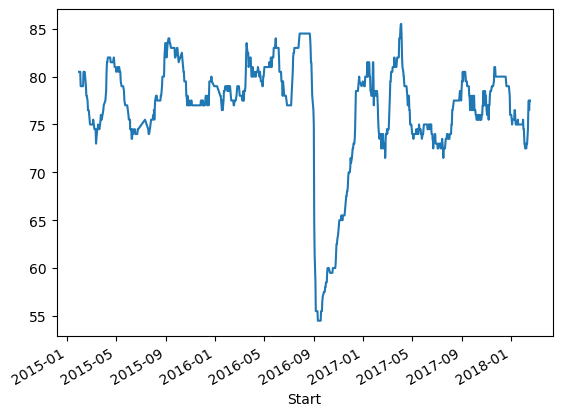

In [55]:
df = df.sort_values("Start")
df.set_index("Start")["Sleep quality"].rolling(30).median().plot()


In [57]:
df.groupby("Day")["Sleep quality"].median()


Day
Friday       77.0
Monday       75.0
Saturday     79.0
Sunday       81.0
Thursday     76.0
Tuesday      76.0
Wednesday    77.0
Name: Sleep quality, dtype: float64

We see here that sleep quality seems to be better on the weekends

Do sleep quality correlate with itself

<Figure size 800x400 with 0 Axes>

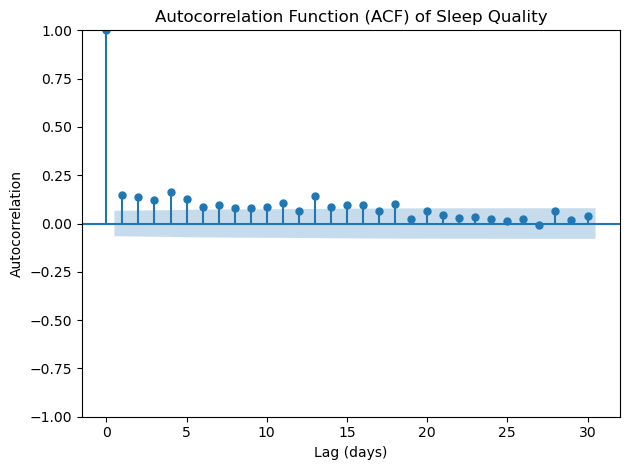

In [59]:
# Ensure data is time-ordered
df = df.sort_values("Start")

# # Extract the target series and drop missing values
# sleep_quality = df["Sleep quality"].dropna()

plt.figure(figsize=(8, 4))
plot_acf(
    df["Sleep quality"].dropna(),
    lags=30,        # adjust depending on how many days you want to inspect
    alpha=0.05      # 95% confidence interval
)
plt.title("Autocorrelation Function (ACF) of Sleep Quality")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()


There is weak but statistically detectable short-term autocorrelation, but no strong or persistent autocorrelation in sleep quality. Between lags 1 to 5, several points slightly exceed the confidence bounds.
This means sleep quality shows short-term dependence: a good or bad night mildly influences the next few nights.

This is consistent with:

- Fatigue accumulation
- Recovery effects
- Habitual routines

Between lags 6 to 15, correlations decay steadily and most values fall inside the confidence interval. This means any temporal influence weakens quickly; there is no medium-term memory.

Lags >15, correlations hover around zero, entirely within the confidence bounds. This means that sleep quality behaves as approximately independent beyond ~2 weeks.